In [3]:
from readRinexObs import rinexobs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from glob import glob

In [4]:
data = rinexobs("mah22800.15o")

mah22800.15o is a RINEX 2.11 file, 15777.532 kB.
16.20 seconds for _block2df
8.03 seconds for panel assignments
finished in 26.16 seconds


In [22]:
f1 = 1575.42E6 #MHz
f2 = 1227.6E6  #MHz
nans = np.logical_or.reduce((np.isnan(data[:,23,'L1','data']),
                          np.isnan(data[:,23,'L2','data']),
                          np.isnan(data[:,23,'C1','data']),
                          np.isnan(data[:,23,'P2','data'])))
inarc=False
start=[]
end=[]
phase=2.85E9*(data[:,23,'L1','data']/f1-data[:,23,'L2','data']/f2)
lgi=0
maxjump=2.0
maxgap=3

for i in range(len(nans)):
    if inarc:
        if(nans[i]):
            if(i-lgi>maxjump):
                inarc=False
                end.append(lgi)
        else:
            if abs(phase[i]-phase[lgi])>maxjump:
                end.append(lgi)
                start.append(i)
            lgi=i
    else:
        if not nans[i]:
            inarc=True
            lgi=i
            start.append(i)
                
ranges = [(data.labels[a],data.labels[b]) for a,b in zip(start,end)]
print(ranges)


[(Timestamp('2015-10-07 06:00:49'), Timestamp('2015-10-07 06:00:49')), (Timestamp('2015-10-07 06:00:51'), Timestamp('2015-10-07 06:20:11')), (Timestamp('2015-10-07 06:20:13'), Timestamp('2015-10-07 06:35:56')), (Timestamp('2015-10-07 06:35:57'), Timestamp('2015-10-07 07:51:11')), (Timestamp('2015-10-07 07:51:13'), Timestamp('2015-10-07 08:40:04')), (Timestamp('2015-10-07 08:46:05'), Timestamp('2015-10-07 08:48:45')), (Timestamp('2015-10-07 08:49:39'), Timestamp('2015-10-07 08:50:44')), (Timestamp('2015-10-07 08:52:01'), Timestamp('2015-10-07 08:56:43'))]


In [20]:
nans[1162]

True

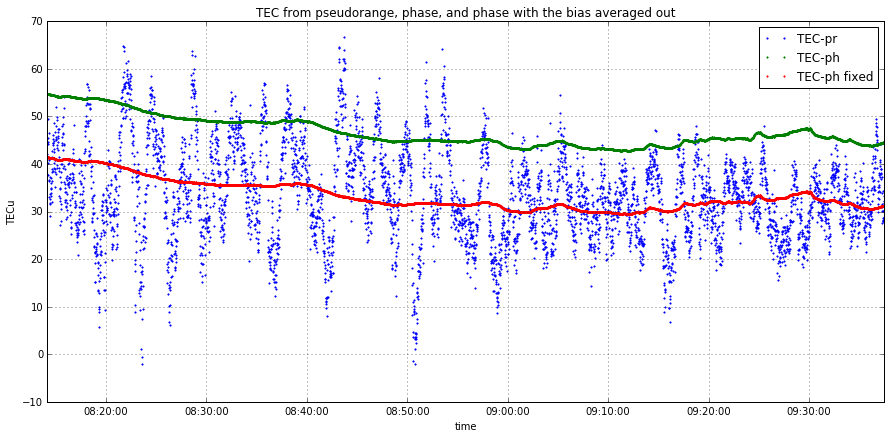

In [5]:
f1 = 1575.42E6 #MHz
f2 = 1227.6E6  #MHz
f5 = 1176.45E6 #MHz

sv_of_interest = 30

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(211)
fmt = DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(fmt)


TEC_pr = 2.85E9*(data[:,sv_of_interest,'C2','data'][8000:13000]/3.0E8
                 -data[:,sv_of_interest,'C1','data'][8000:13000]/3.0E8)

TEC_ph = 2.85E9*(data[:,sv_of_interest,'L1','data'][8000:13000]/f1
                 -data[:,sv_of_interest,'L2','data'][8000:13000]/f2)

bias = np.average((TEC_ph-TEC_pr)[np.logical_not(np.isnan(TEC_ph-TEC_pr))])

TEC_ph2 = 2.85E9*((data[:,sv_of_interest,'L1','data'][8000:13000])/f1
                  -(data[:,sv_of_interest,'L2','data'][8000:13000])/f2)-bias

plt.plot(TEC_pr,'.',label='TEC-pr',markersize=3)
plt.plot(TEC_ph,'.',label='TEC-ph',markersize=3)
plt.plot(TEC_ph2,'.',label='TEC-ph fixed',markersize=3)

plt.legend()
plt.title('TEC from pseudorange, phase, and phase with the bias averaged out')
plt.ylabel('TECu')
plt.xlabel('time')
plt.grid()
plt.show()


These graphs have all been produced according to appendix A of "Effect of GPS System Biases on Differential
Group Delay Measurements" available here: http://www.dtic.mil/dtic/tr/fulltext/u2/a220284.pdf. It is referenced in Anthea Coster's 1992 paper "Ionospheric Monitoring System". Equation 2.3 in the paper states that TEC in TECu is equal to the propogation time difference between the two frequencies. In order to find the propogation time, I divided the distance by the speed of light. I did the same thing with the phase but first I had to multiply the cycles (which is available from the rinex file) by the wavelength. 

Basically what I want to explore with this notebook is combining pseudorange and phase data to get better TEC plots. Pseudorange is an absolute measurement but is subject to a lot of noise. Phase is low noise but has an unknown cycle ambiguity. According to the previously mentioned paper, the cycle ambiguity in phase data can be estimated by finding the average difference between the pseudorange and phase. In this script I converted pseudorange into cycles by dividing by wavelength. Then I calculated TEC according to equation 2.3 and plotted it next to the pseudorange calculated TEC and the biased phase calculated TEC.

Shown above is only a short time period free of cycle slips and loss of lock. In order to implement this averaging strategy, I think you have to re-average every time there is a cycle slip or missing data.

In [6]:
files = glob("/home/greg/Documents/Summer Research/rinex files/ma*")
poop=rinexobs(files[6])

/home/greg/Documents/Summer Research/rinex files/ma132800.15o is a RINEX 2.11 file, 37095.507 kB.
36.11 seconds for _block2df
21.72 seconds for panel assignments
finished in 61.72 seconds


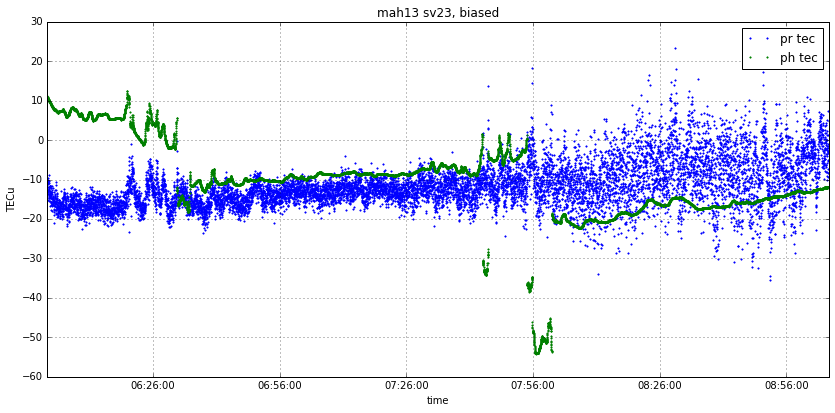

In [7]:
plt.figure(figsize=(14,14))
ax1 = plt.subplot(211)
ax1.xaxis.set_major_formatter(fmt)

plt.plot(2.85*(poop[:,23,'P2','data']*1.0E9/3.0E8-poop[:,23,'C1','data']*1.0E9/3.0E8)[10:],
         '.',markersize=3,label='pr tec')
plt.plot(2.85E9*((poop[:,23,'L1','data'])/f1-(poop[:,23,'L2','data'])/f2)[10:],
         '.',markersize=3,label='ph tec')

plt.title('mah13 sv23, biased')
plt.xlabel('time')
plt.ylabel('TECu')
plt.legend()
plt.grid()
plt.show()


This plot is uncorrected, it is a remake of the plot in Anthea's email on Wed, Jun 15, 2016 at 7:06 AM. The phase calculated TEC appears to match the pseudorange calculated TEC in parts, but other parts are offset by a bias. The next script and plot shows how the phase data can be shifted to line up with the average of the pseudorange data. It does so according to how large the slice value is. Basically it slices up the whole data set into a specifiable range of points and does the averaging on each range of points individually in order to fix phase lock cycle slips. This isn't the best way of doing it, the program should check for loss of lock and shift the phase data in chunks based on that. I am going to read more about cycle slips now.

/home/greg/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


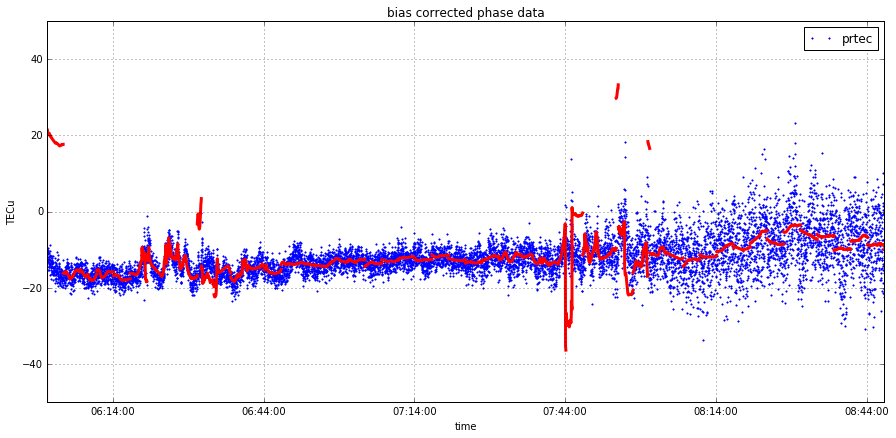

In [8]:
sl=200
plt.figure(figsize=(15,15))
ax1=plt.subplot(211)
ax1.xaxis.set_major_formatter(fmt)

plt.plot(2.85E9*(poop[:,23,'P2','data']/3.0E8
                 -poop[:,23,'C1','data']/3.0E8),'b.',label='prtec',markersize=3)

for i in range(int(len(poop[:,23,'L1','data'])/sl)):

    phtec = 2.85E9*(poop[poop.labels[sl*i:sl*(i+1)],23,'L1','data']/f1
                   -poop[poop.labels[sl*i:sl*(i+1)],23,'L2','data']/f2)
          
    prtec = 2.85E9*(poop[poop.labels[sl*i:sl*(i+1)],23,'P2','data']/3.0E8
                   -poop[poop.labels[sl*i:sl*(i+1)],23,'C1','data']/3.0E8)
    
    b = np.average((phtec-prtec)[np.logical_not(np.isnan(phtec-prtec))])
    plt.plot(phtec-b,'r-',linewidth=3,label='')
    

plt.axis([poop.labels[10],poop.labels[10000],-50,50])
plt.title('bias corrected phase data')
plt.xlabel('time')
plt.ylabel('TECu')
plt.grid()
plt.legend()
plt.show()



try some stuff out from "An Automatic Editing Algorithm for GPS Data" by Blewitt

In [9]:
f1 = 1575.42E6 
f2 = 1227.6E6  

svn = 23
L1 = -1*3.0E8*poop[:,svn,'L1','data']/f1  #(1a)
L2 = -1*3.0E8*poop[:,svn,'L2','data']/f2  #(1b)
P1 = poop[:,svn,'C1','data']              #(1c)
P2 = poop[:,svn,'P2','data']              #(1d)


#wide lane combination
wld = 3.0E8/(f1-f2)
Ld = (f1*L1-f2*L2)/(f1-f2)                #(3)
prd = (f1*P1+f2*P2)/(f1+f2)               #(4)
bd = (Ld-prd)/wld                         #(5)

#wide lane cycle slip detection
bdmean = bd[1]
rms = 0
nans_in_a_row = 0
bdindex=2
ph_con_arc=0
avb=[]
rmsb=[]
lowers=[]
uppers=[]
inarc=False

while(nans_in_a_row<10):
    
    if not np.isnan(bd[bdindex]):
        
        if(bd[i]>4*np.sqrt(rms)):
            avb.append(bdmean)
            rmsb.append(np.sqrt(rms))
            bdmean=bd[i+1]
            rms=0
            ph_con_arc=0
            uppers.append(bdindex)
            inarc=False
            
        else:
            if not inarc:
                inarc=True
                lowers.append(bdindex)
            ph_con_arc+=1
            nans_in_a_row=0
            rms = rms+((bd[bdindex]-bdmean)**2-rms)/(ph_con_arc) #(8b)
            bdmean = bdmean+(bd[bdindex]-bdmean)/(ph_con_arc)    #(8a)
            
    else:
        if inarc:
            avb.append(bdmean)
            rmsb.append(rms)
            ph_con_arc=0
            bdmean=bd[bdindex+1]
            rms=0
            inarc=False
            uppers.append(bdindex)
        nans_in_a_row += 1
    bdindex+=1
            
print('ended at index {}'.format(bdindex-nans_in_a_row))

lengths=[a-b for a,b in zip(uppers,lowers)]
eim = [np.sqrt(a)/np.sqrt(b-1) for a,b in zip(rmsb,lengths)]
        

#ionospheric combination
LI = L1-L2      #(6)
PI = P2-P1      #(7)

#ionospheric cycle slip detection
# get x and y vectors
mask=~np.isnan(PI)
x = np.arange(len(PI[mask]))
y = PI[mask]

# calculate polynomial
z = np.polyfit(x, y, 6)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], len(x))
Q = f(x_new)

residual = LI[mask]-Q



ended at index 11110


[2, 1850, 6826, 7162, 7178] [1849, 6825, 7161, 7177, 11110]


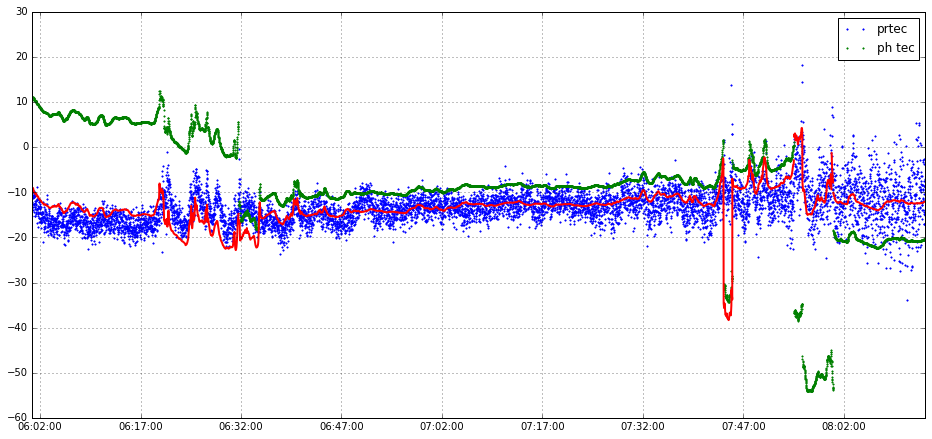

In [26]:
print(lowers,uppers)
plt.figure(figsize=(16,16))
plt.subplot(211).xaxis.set_major_formatter(fmt)
plt.plot(2.85E9*(poop[:,23,'P2','data']/3.0E8
                 -poop[:,23,'C1','data']/3.0E8),'b.',label='prtec',markersize=3)
plt.plot(2.85E9*((poop[:,23,'L1','data'])/f1-(poop[:,23,'L2','data'])/f2)[10:],
         'g.',markersize=3,label='ph tec')
for i in range(len(lowers)):

    phtec = 2.85E9*(poop[poop.labels[lowers[i]:uppers[i]],23,'L1','data']/f1
                   -poop[poop.labels[lowers[i]:uppers[i]],23,'L2','data']/f2)
          
    prtec = 2.85E9*(poop[poop.labels[lowers[i]:uppers[i]],23,'P2','data']/3.0E8
                   -poop[poop.labels[lowers[i]:uppers[i]],23,'C1','data']/3.0E8)
    
    b = np.average((phtec-prtec)[np.logical_not(np.isnan(phtec-prtec))])
    plt.plot(phtec-b,'r-',linewidth=2,label='')
    
plt.xlim([poop.labels[1],poop.labels[8000]])
plt.legend()
plt.grid()
plt.show()
